# Ridge and Lasso analysis of Franke's function

### defining imports

In [1]:
#All imports
import numpy as np
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression, Ridge, Lasso

import warnings
warnings.filterwarnings('ignore')

### Defining functions for later use

#### Function for 3D plotting

In [2]:
#Quick Plotting function

def plotting3D(x, y, z, text):
    fig = plt.figure(figsize = (13, 7))
    ax = fig.add_subplot(projection='3d') #


    surf = ax.plot_surface(x, y, z, cmap = cm.coolwarm,
    linewidth = 0, antialiased = False)

    #predict_surf = ax.plot_trisurf(x, y, zpredict, cmap = cm.coolwarm,
    #linewidth = 0, antialiased = False)
    # Customize the z axis.
    ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title(text, fontsize = 15)
    plt.show()

#### Function for R2 and MSE estimates

In [3]:
#MSE and R2
#Taken from courses jupyterbook
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

#### Franke's function

In [4]:
#Franke function:
#Taken from assignment paper
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

#### Function for creating design matrix

In [5]:
#Function that creates design matrix for Franke's function
#Taken from courses jupyterbook
def create_X(x, y, n): #design matrices for polynomials up to 10th degree
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    #print(f'Features/Length beta: {l}') #what amount should we expect?
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)
    return X

#### Function for performing bootstrap resampling method for OLS

In [6]:
#Bootstrap function for OLS
def bootstrap(X, z, bootstrap_n):
    beta = np.zeros([bootstrap_n, np.shape(X)[1]])
    n_samples = np.shape(X)[0] - 10
    for i in range(bootstrap_n):
        X_n, z_n = resample(X, z, replace=True, n_samples=None)
        beta[i] = np.linalg.pinv(X_n.T @ X_n) @ X_n.T @ z_n
    beta_bootstrapped = np.mean(beta, axis=0)
    
    return beta_bootstrapped

#### Function for performing bootstrap resampling method for Ridge

In [7]:
#Bootstrap function for Ridge with defined lambda
def bootstrap_ridge(X, z, bootstrap_n, lambd):
    beta = np.zeros([bootstrap_n, np.shape(X)[1]])
    n_samples = np.shape(X)[0] - 10
    I = np.eye(np.shape(X_train)[1],np.shape(X_train)[1])
    for i in range(bootstrap_n):
        X_n, z_n = resample(X, z, replace=True, n_samples=None)
        beta[i] = np.linalg.pinv(X_n.T @ X_n + lambd*I) @ X_n.T @ z_n
    beta_bootstrapped = np.mean(beta, axis=0)
    
    return beta_bootstrapped

#### Ridge analysis with sklearn

In [8]:
def RidgeAnalysis_bootstrap(n_bootstrap, lmd, X_train, X_test, z_train, z_test):
    z_pred = np.empty((n_bootstraps, z_test.shape[0]))
    for i in range(n_bootstrap):
        X_train_, z_trian_ = resample(X_train, z_train)
        ridge = Ridge(alpha = lmd)
        ridge.fit(X_train, z_train)
        z_pred[i] = ridge.predict(X_test).ravel()
    z_pred_f = np.mean(z_pred, axis = 0)
    
    return z_pred

### Generating vanilla datapoints with noise

In [9]:
N = 40 #Number of datapoints
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))

x_, y_ = np.meshgrid(x,y)

#Adding noise:
var = 0.1
noise = np.random.normal(0, var, len(x_)*len(x_))
noise = noise.reshape(len(x_), len(x_))

z_noNoise = FrankeFunction(x_, y_)
z =  FrankeFunction(x_, y_) + noise 

#plotting3D(x_, y_, z_noNoise, "plot of our surface without noise")
#plotting3D(x_, y_, z, "plot of our surface with noise")

#Choose the complexity of our approximation to be polynomial degree 5.
#Creating design matrix
X = create_X(x_, y_, n = 5)
#Splitting the data into test and train sets
X_train, X_test, z_train, z_test = train_test_split(X, np.ravel(z), test_size=0.2, shuffle=True)

### Finding the optimal lambda value for our Ridge approximation with scaling

In [10]:
nlambdas = 100 #number of trial lambdas
lambdas = np.logspace(-15,15, nlambdas)


#Scaling the dataset:
X_train_scaled = X_train - np.mean(X_train)
z_train_scaled = z_train - np.mean(z_train)

MSE_predict = np.zeros(nlambdas)
MSE_predict_bootstrap = np.zeros(nlambdas)
I = np.eye(np.shape(X_train)[1],np.shape(X_train)[1]) #Defining the identity matrix that is used to calculate RidgeBeta
for i in range(nlambdas):
    lmb = lambdas[i]
    RidgeBeta = np.linalg.inv(X_train_scaled.T@X_train_scaled + lmb*I) @ X_train_scaled.T @ z_train_scaled
    X_test_un = X_test - np.mean(X_train)
    z_pred = (X_test_un @ RidgeBeta) + np.mean(z_train)
    MSE_predict[i] = MSE(np.ravel(z_test), z_pred)
    
#     RidgeBetaBootstrap =  bootstrap_ridge(X_train_scaled, z_train_scaled, bootstrap_n = 50, lambd = lmb)
#     z_pred_bootstrap = (X_test @ RidgeBetaBootstrap) + np.mean(z_train)
#     MSE_predict_bootstrap[i] = MSE(np.ravel(z_test), z_pred_bootstrap)

In [11]:
#Finding the optimal value
min_value_index = np.where(MSE_predict == np.min(MSE_predict))
formatted_lambda = ("{:.3f}".format(lambdas[min_value_index][0]))
print(f"The most optimal lambda is {formatted_lambda}")
print(f"with MSE value of {MSE_predict[min_value_index][0]}")

The most optimal lambda is 0.000
with MSE value of 0.010314483647820121


#### Visualization

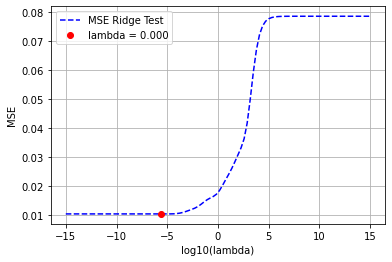

In [12]:
plt.plot(np.log10(lambdas), MSE_predict, 'b--', label = 'MSE Ridge Test')
plt.plot(np.log10(lambdas[min_value_index][0]), MSE_predict[min_value_index][0], 'ro', label = f"lambda = {formatted_lambda}")
#plt.plot(np.log10(lambdas), MSE_predict_bootstrap, 'r--', label = 'MSE Ridge Test with bootstrap')
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.grid(1)
plt.legend()
plt.show()

### Lasso regression

In [13]:
# Decide which values of lambda to use
nlambdas = 100


MSELassoPredict = np.zeros(nlambdas)
MSELassoTrain = np.zeros(nlambdas)
lambdas = np.logspace(-10, 10, nlambdas)

#Scaling:
X_train_scaled = X_train - np.mean(X_train)
z_train_scaled = z_train - np.mean(z_train)

for i in range(nlambdas):
    lmb = lambdas[i]
    RegLasso = Lasso(lmb)
    RegLasso.fit(X_train_scaled,z_train_scaled)
    
    X_test_un = X_test - np.mean(X_train)
    ypredictLasso = RegLasso.predict(X_test_un)
    MSELassoPredict[i] = MSE(z_test,ypredictLasso) + np.mean(z_train)


In [14]:
#Finding the optimal value
min_value_index = np.where(MSELassoPredict == np.min(MSELassoPredict))
formatted_lambda = ("{:.3f}".format(lambdas[min_value_index][0]))
print(f"The most optimal lambda is {formatted_lambda}")
print(f"with MSE value of {MSELassoPredict[min_value_index][0]}")

The most optimal lambda is 0.000
with MSE value of 0.5559262121686308


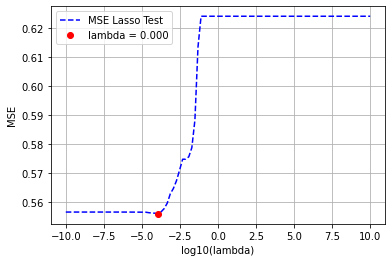

In [17]:
# Now plot the results
plt.figure()
plt.plot(np.log10(lambdas), MSELassoPredict, 'b--', label = 'MSE Lasso Test')
plt.plot(np.log10(lambdas[min_value_index][0]), MSELassoPredict[min_value_index][0], 'ro', label = f"lambda = {formatted_lambda}")
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

## Extras

### Bias-variance analysis for ridge with scaling

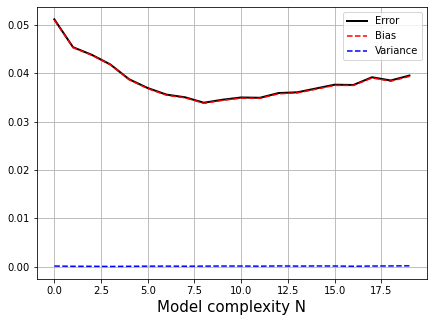

In [16]:
n_boostraps = 10
maxdegree = 20

error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)


model = Ridge(alpha = 5.77) #instance of linreg class

for degree in range(maxdegree):
    X_ = create_X(x_, y_, degree+1)
    X_train_, X_test_, z_train_, z_test_ = train_test_split(X_, z.ravel(), test_size=0.2, random_state = 40)
    z_pred = np.empty((z_test_.shape[0], n_boostraps))
    
    X_train_scaled = X_train_ - np.mean(X_train)
    z_train_scaled = z_train_ - np.mean(z_train)
    
    for i in range(n_boostraps): #how to do this in 3d?
        X_, z_ = resample(X_train_scaled, z_train_scaled)
        X_test_un = X_test_ - np.mean(z_train_)
        z_pred[:, i] = model.fit(X_, z_).predict(X_test_un).ravel() + np.mean(z_train)

    polydegree[degree] = degree

    error[degree] = np.mean( np.mean((z_test_.reshape(-1, 1) - z_pred)**2, axis=1, keepdims=True) )
    bias[degree] = np.mean( (z_test_.reshape(-1, 1) - np.mean(z_pred, axis=1, keepdims=True))**2 )
    variance[degree] = np.mean( np.var(z_pred, axis=1, keepdims=True) )
    
    

fig = plt.figure(figsize = (7, 5)) 
plt.plot(polydegree, error, 'k', label='Error', linewidth = 2)
plt.plot(polydegree, bias, 'r--', label='Bias', linewidth = 1.5)
plt.plot(polydegree, variance, 'b--', label='Variance', linewidth = 1.5)
plt.xlabel('Model complexity N', fontsize = 15)
plt.legend(); plt.grid(1); plt.show()